In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets , transforms
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
transform = transforms.Compose([ transforms.ToTensor() , transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
train = datasets.CIFAR10(root="./data" , train=True , transform=transform , download=True)
test = datasets.CIFAR10(root="./data" , train=False , transform=transform , download=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_size= int((1 - 0.2)*len(train))
val_size = len(train) - train_size
train , val = random_split(train , [train_size,val_size])

In [ ]:
train_data = DataLoader(train , batch_size = 32 , shuffle = True)
val_data = DataLoader(val , batch_size = 32 , shuffle = False)
test_data = DataLoader(test , batch_size = 32 , shuffle = False)

In [ ]:
# Check the shape of one batch
for images, labels in train_data:
    print("Image batch dimensions:", images.shape)
    print("Label batch dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 32, 32])
Label batch dimensions: torch.Size([32])


In [ ]:
train_data

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=64 ,kernel_size=4 ,stride=1 , padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels=32 ,kernel_size=4 ,stride=1 , padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*8*8,256)
        self.output = nn.Linear(256,10)

    def forward(self,input_data):
        out = self.maxpool1(F.relu(self.conv1(input_data)))
        out = self.maxpool2(F.relu(self.conv2(out)))
        out = out.view(out.size(0) , -1)
        out = F.relu(self.hidden(out))
        out = self.output(out)
        return out

In [ ]:
start = datetime.now()
best = float('inf')
val_losses=[]
train_losses=[]
epoch_without_imporove = 0
stop_training = False
patience =10

model = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
for i in range(100):
    model.train()
    run_loss = 0
    correct = 0
    total = 0
    if stop_training:
        print("Early stopping triggered")
        break
    for image , label in train_data:


        optimizer.zero_grad()
        output = model(image)
        loss = loss_func(output , label)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        _,predict = torch.max(output.data , dim=1)
        total += label.size(0)
        correct +=(predict ==label).sum().item()
    test_accuracy = 100 * correct / total
    epoch_train_loss =run_loss / len(train_data)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for image,label in val_data:
            val_output = model(image)
            v_loss = loss_func(val_output , label)
            val_loss +=v_loss.item()
            _,predict = torch.max(val_output.data , dim=1)
            val_total += label.size(0)
            val_correct +=(predict ==label).sum().item()
    epoch_val_loss = val_loss / len(val_data)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * val_correct / val_total
    print(f'train Accuracy of the model on the 8000 train images: {test_accuracy:.2f}%')
    print(f"in epoch {i+1} , i have train loss {epoch_train_loss}")
    print(f'validation Accuracy of the model on the 2000 validation images: {val_accuracy:.2f}%')
    print(f"in epoch {i+1} , i have validation loss {epoch_val_loss}")
    print()
    if epoch_val_loss < best:
        best = epoch_val_loss
        epoch_without_imporove = 0
    else:
        epoch_without_imporove +=1
        if(epoch_without_imporove> patience):
            stop_training= True

end= datetime.now()

C:\Users\ZETTA\anaconda3\lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


train Accuracy of the model on the 8000 train images: 50.42%
in epoch 1 , i have train loss 1.3753388803005218
validation Accuracy of the model on the 2000 validation images: 60.61%
in epoch 1 , i have validation loss 1.1094123940117442

train Accuracy of the model on the 8000 train images: 63.98%
in epoch 2 , i have train loss 1.0158663954496383
validation Accuracy of the model on the 2000 validation images: 64.58%
in epoch 2 , i have validation loss 1.0074869679947631

train Accuracy of the model on the 8000 train images: 69.78%
in epoch 3 , i have train loss 0.8569126113653183
validation Accuracy of the model on the 2000 validation images: 67.82%
in epoch 3 , i have validation loss 0.9198538766691859

train Accuracy of the model on the 8000 train images: 73.92%
in epoch 4 , i have train loss 0.7403430739641189
validation Accuracy of the model on the 2000 validation images: 69.28%
in epoch 4 , i have validation loss 0.8976518137576862

train Accuracy of the model on the 8000 train im

In [ ]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for image,label in test_data:
        test_output = model(image)
        _,predict = torch.max(test_output.data , dim=1)
        test_total += label.size(0)
        test_correct +=(predict ==label).sum().item()

    accuracy = 100 * test_correct / test_total
    print(f'test Accuracy of the model on the test images: {accuracy:.2f}%')



test Accuracy of the model on the test images: 67.96%


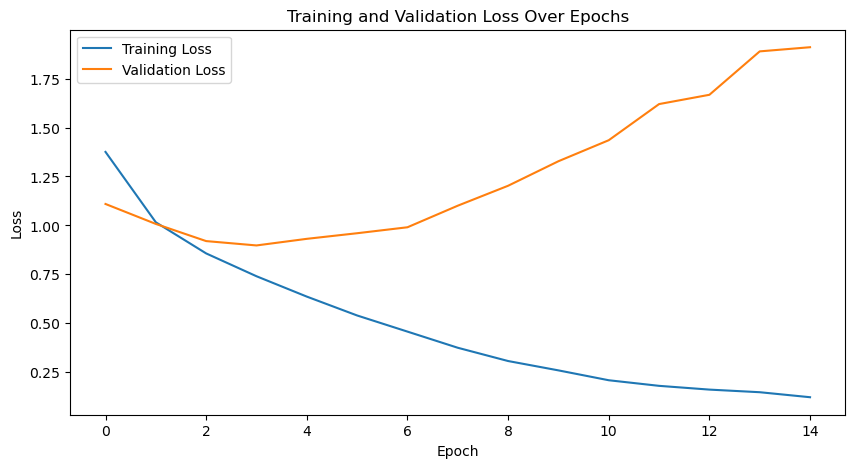

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
print(f"time for convergenece : {end - start}")

time for convergenece : 0:22:05.698088


In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1 ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 ,kernel_size=4 ,stride=1 , padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=4 ,stride=1 , padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*8*8,256)
        self.dropout=nn.Dropout(p=0.3)
        self.output = nn.Linear(256,10)


    def forward(self,input_data):
        out = self.maxpool1(F.relu(self.conv1(input_data)))
        out = self.maxpool2(F.relu(self.conv2(out)))
        out = out.view(out.size(0) , -1)
        out = F.relu(self.hidden(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [2]:
def training(network , train_data , val_data , optimizer,loss_func,filename,patience=5 ):
    start_time = datetime.now()
    model1 = network
    best1 = float('inf')
    val_losses1=[]
    train_losses1=[]
    epoch_without_imporove =0
    stop_training = False
    patience = 5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    for i in range(100):
        model1.train()
        run_loss = 0
        correct = 0
        total = 0
        if stop_training:
            print("Early stopping triggered")
            break
        for image , label in train_data:
            image, label = image.to(device), label.to(device)


            optimizer.zero_grad()
            output = model1(image)
            loss = loss_func(output , label)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
            _,predict = torch.max(output.data , dim=1)
            total += label.size(0)
            correct +=(predict ==label).sum().item()
        test_accuracy = 100 * correct / total
        epoch_train_loss =run_loss / len(train_data)
        train_losses1.append(epoch_train_loss)

        model1.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for image,label in val_data:
                image, label = image.to(device), label.to(device)
                val_output = model1(image)
                v_loss = loss_func(val_output , label)
                val_loss +=v_loss.item()
                _,predict = torch.max(val_output.data , dim=1)
                val_total += label.size(0)
                val_correct +=(predict ==label).sum().item()
        epoch_val_loss = val_loss / len(val_data)
        val_losses1.append(epoch_val_loss)
        val_accuracy = 100 * val_correct / val_total
        print(f'train Accuracy of the model on the 8000 train images: {test_accuracy:.2f}%')
        print(f"in epoch {i+1} , i have train loss {epoch_train_loss}")
        print(f'validation Accuracy of the model on the 2000 validation images: {val_accuracy:.2f}%')
        print(f"in epoch {i+1} , i have validation loss {epoch_val_loss}")
        print()
        if epoch_val_loss < best1:
            best1 = epoch_val_loss
            epoch_without_imporove = 0
            torch.save(model1.state_dict(), filename)
        else:
            epoch_without_imporove +=1
            if(epoch_without_imporove> patience):
                stop_training= True

    end_time = datetime.now()
    return model1,val_losses1,train_losses1,end_time - start_time

In [ ]:

model_32 = CNN1()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_32.parameters(),lr=0.001)
model_32 , v_losses_list , t_losses_list , time = training(model_32,train_data , val_data , optimizer , loss_func,'model_32.pth')

train Accuracy of the model on the 8000 train images: 47.38%
in epoch 1 , i have train loss 1.4640639135360718
validation Accuracy of the model on the 2000 validation images: 57.56%
in epoch 1 , i have validation loss 1.1732656723394181

train Accuracy of the model on the 8000 train images: 60.60%
in epoch 2 , i have train loss 1.1117218493938446
validation Accuracy of the model on the 2000 validation images: 64.11%
in epoch 2 , i have validation loss 1.002541979852195

train Accuracy of the model on the 8000 train images: 66.29%
in epoch 3 , i have train loss 0.9563418927192688
validation Accuracy of the model on the 2000 validation images: 66.63%
in epoch 3 , i have validation loss 0.9567344093475098

train Accuracy of the model on the 8000 train images: 69.69%
in epoch 4 , i have train loss 0.8536035235643387
validation Accuracy of the model on the 2000 validation images: 69.06%
in epoch 4 , i have validation loss 0.8872576759646114

train Accuracy of the model on the 8000 train ima

In [3]:
def testing(network , test_data):
    model = network
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for image,label in test_data:
            image, label = image.to(device), label.to(device)

            test_output = model(image)
            _,predict = torch.max(test_output.data , dim=1)
            test_total += label.size(0)
            test_correct +=(predict ==label).sum().item()

        accuracy = 100 * test_correct / test_total
        print(f'test Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy


In [ ]:
model_32_res = testing(model_32,test_data)

test Accuracy of the model on the test images: 70.70%


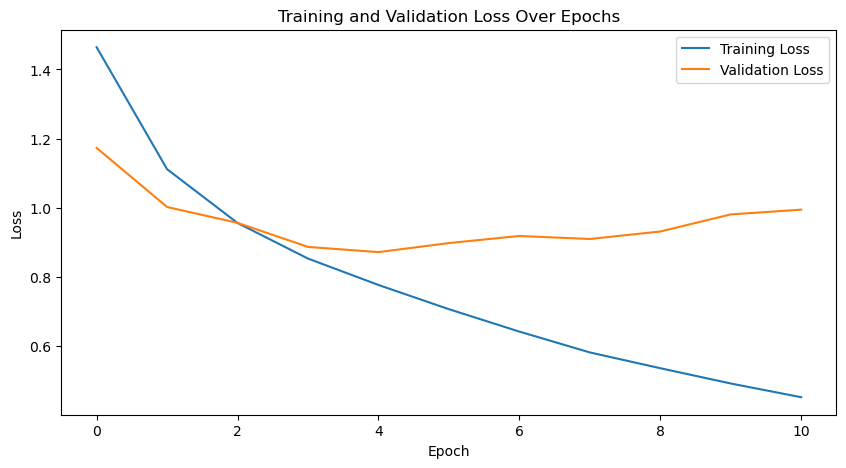

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list, label='Training Loss')
plt.plot(v_losses_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
print(f"time for convergenece : {time}")

time for convergenece : 0:11:49.832596


In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2 ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.conv3 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*4*4,256)
        self.dropout=nn.Dropout(p=0.3)
        self.output = nn.Linear(256,10)


    def forward(self,input_data):
        out = self.maxpool(F.relu(self.conv1(input_data)))
        out = self.maxpool(F.relu(self.conv2(out)))
        out = self.maxpool(F.relu(self.conv3(out)))
        out = out.view(out.size(0) , -1)
        out = F.relu(self.hidden(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [ ]:
model_3layers = CNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3layers.parameters(),lr=0.001)
model_3layers , v_losses_list1 , t_losses_list1 , time1 = training(model_3layers,train_data , val_data , optimizer , loss_func,'model_3layers.pth')

train Accuracy of the model on the 8000 train images: 42.96%
in epoch 1 , i have train loss 1.5431371780872345
validation Accuracy of the model on the 2000 validation images: 54.62%
in epoch 1 , i have validation loss 1.2407785404604463

train Accuracy of the model on the 8000 train images: 57.67%
in epoch 2 , i have train loss 1.1770962128162383
validation Accuracy of the model on the 2000 validation images: 61.74%
in epoch 2 , i have validation loss 1.0738214574301967

train Accuracy of the model on the 8000 train images: 63.17%
in epoch 3 , i have train loss 1.03170723464489
validation Accuracy of the model on the 2000 validation images: 64.30%
in epoch 3 , i have validation loss 1.0031646278719553

train Accuracy of the model on the 8000 train images: 66.33%
in epoch 4 , i have train loss 0.9425076335430145
validation Accuracy of the model on the 2000 validation images: 68.13%
in epoch 4 , i have validation loss 0.9089901609161791

train Accuracy of the model on the 8000 train imag

In [ ]:
model_3layers_res = testing(model_3layers ,test_data )

test Accuracy of the model on the test images: 71.42%


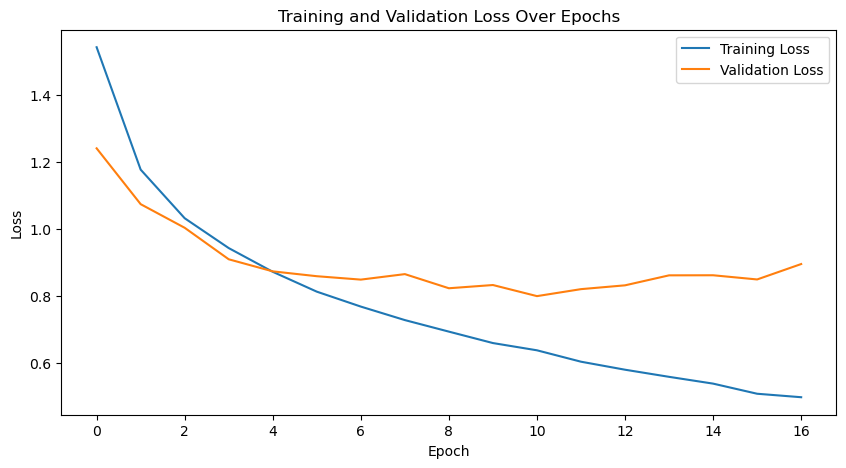

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list1, label='Training Loss')
plt.plot(v_losses_list1, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time1

datetime.timedelta(seconds=959, microseconds=549657)

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3 ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.conv3 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.conv4 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*2*2,256)
        self.dropout=nn.Dropout(p=0.3)
        self.output = nn.Linear(256,10)


    def forward(self,input_data):
        out = self.maxpool(F.relu(self.conv1(input_data)))
        out = self.maxpool(F.relu(self.conv2(out)))
        out = self.maxpool(F.relu(self.conv3(out)))
        out = self.maxpool(F.relu(self.conv4(out)))
        out = out.view(out.size(0) , -1)
        out = F.relu(self.hidden(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [ ]:
model_4layers = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4layers.parameters(),lr=0.001)
model_4layers , v_losses_list2 , t_losses_list2 , time2 = training(model_4layers,train_data , val_data , optimizer , loss_func,'model_4layers.pth')

train Accuracy of the model on the 8000 train images: 40.45%
in epoch 1 , i have train loss 1.606284263086319
validation Accuracy of the model on the 2000 validation images: 50.84%
in epoch 1 , i have validation loss 1.3375405669212341

train Accuracy of the model on the 8000 train images: 56.50%
in epoch 2 , i have train loss 1.2156061469078063
validation Accuracy of the model on the 2000 validation images: 58.76%
in epoch 2 , i have validation loss 1.1461983045069173

train Accuracy of the model on the 8000 train images: 62.48%
in epoch 3 , i have train loss 1.0509734302520752
validation Accuracy of the model on the 2000 validation images: 64.58%
in epoch 3 , i have validation loss 1.0015930727647897

train Accuracy of the model on the 8000 train images: 66.10%
in epoch 4 , i have train loss 0.9493544692754745
validation Accuracy of the model on the 2000 validation images: 66.10%
in epoch 4 , i have validation loss 0.9530004602842057

train Accuracy of the model on the 8000 train ima

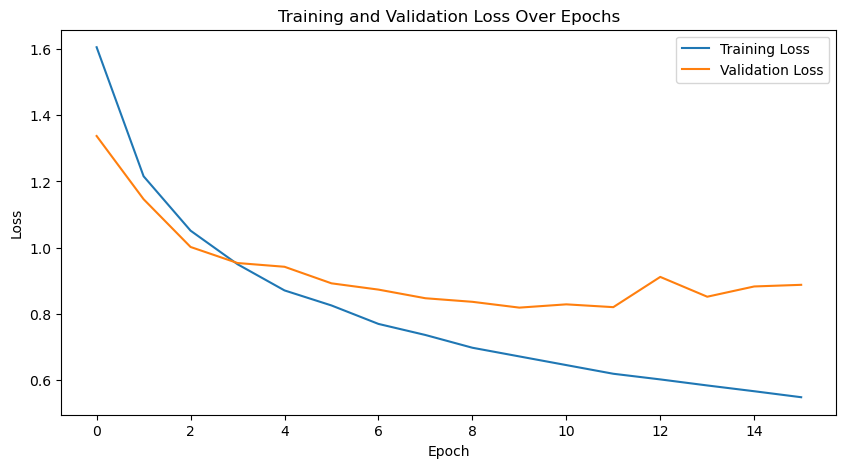

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list2, label='Training Loss')
plt.plot(v_losses_list2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time2

datetime.timedelta(seconds=897, microseconds=592115)

In [ ]:
model_4layers_res = testing(model_4layers , test_data)

test Accuracy of the model on the test images: 71.96%


In [ ]:
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4 ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal4 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*2*2,256)
        self.dropout=nn.Dropout(p=0.3)
        self.output = nn.Linear(256,10)


    def forward(self,input_data):
        out = self.maxpool(F.relu(self.bNormal1(self.conv1(input_data))))
        out = self.maxpool(F.relu(self.bNormal2(self.conv2(out))))
        out = self.maxpool(F.relu(self.bNormal3(self.conv3(out))))
        out = self.maxpool(F.relu(self.bNormal4(self.conv4(out))))
        out = out.view(out.size(0) , -1)
        out = F.relu(self.hidden(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [ ]:
model_BNorm = CNN4()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BNorm.parameters(),lr=0.001)
model_BNorm , v_losses_list3 , t_losses_list3 , time3 = training(model_BNorm,train_data , val_data , optimizer , loss_func,'model_BNorm.pth')

train Accuracy of the model on the 8000 train images: 50.93%
in epoch 1 , i have train loss 1.3413316125392913
validation Accuracy of the model on the 2000 validation images: 60.36%
in epoch 1 , i have validation loss 1.0786186224355485

train Accuracy of the model on the 8000 train images: 64.63%
in epoch 2 , i have train loss 0.9921733332872391
validation Accuracy of the model on the 2000 validation images: 63.49%
in epoch 2 , i have validation loss 1.0467824273216078

train Accuracy of the model on the 8000 train images: 69.54%
in epoch 3 , i have train loss 0.8667330927610397
validation Accuracy of the model on the 2000 validation images: 69.40%
in epoch 3 , i have validation loss 0.8837610847843341

train Accuracy of the model on the 8000 train images: 72.15%
in epoch 4 , i have train loss 0.7901446856021881
validation Accuracy of the model on the 2000 validation images: 68.48%
in epoch 4 , i have validation loss 0.9260331868363646

train Accuracy of the model on the 8000 train im

In [ ]:
model_BNorm_res = testing(model_BNorm , test_data)

test Accuracy of the model on the test images: 74.40%


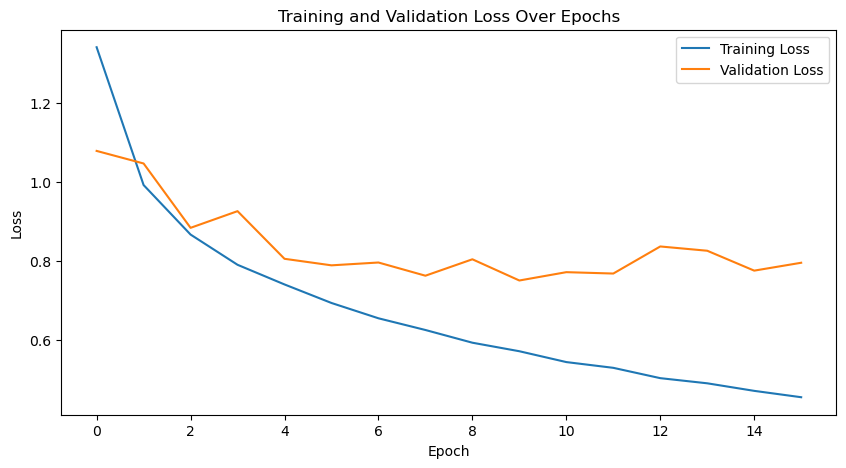

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list3, label='Training Loss')
plt.plot(v_losses_list3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time3

datetime.timedelta(seconds=1003, microseconds=681995)

In [ ]:
model_1_learningrate = CNN4()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_learningrate.parameters(),lr=0.1)
model_1_learningrate , v_losses_list4 , t_losses_list4 , time4 = training(model_1_learningrate,train_data , val_data , optimizer , loss_func,'model_1learningrate.pth')

train Accuracy of the model on the 8000 train images: 10.02%
in epoch 1 , i have train loss 2.4343960277557373
validation Accuracy of the model on the 2000 validation images: 9.94%
in epoch 1 , i have validation loss 2.309497060867163

train Accuracy of the model on the 8000 train images: 10.05%
in epoch 2 , i have train loss 2.315558395195007
validation Accuracy of the model on the 2000 validation images: 10.30%
in epoch 2 , i have validation loss 2.314091243682959

train Accuracy of the model on the 8000 train images: 9.97%
in epoch 3 , i have train loss 2.3157184783935545
validation Accuracy of the model on the 2000 validation images: 9.93%
in epoch 3 , i have validation loss 2.3096044109271356

train Accuracy of the model on the 8000 train images: 9.86%
in epoch 4 , i have train loss 2.3151422496795653
validation Accuracy of the model on the 2000 validation images: 10.20%
in epoch 4 , i have validation loss 2.310891840785456

train Accuracy of the model on the 8000 train images: 10

In [ ]:
model_1_learningrate_res = testing(model_1_learningrate , test_data)

test Accuracy of the model on the test images: 10.00%


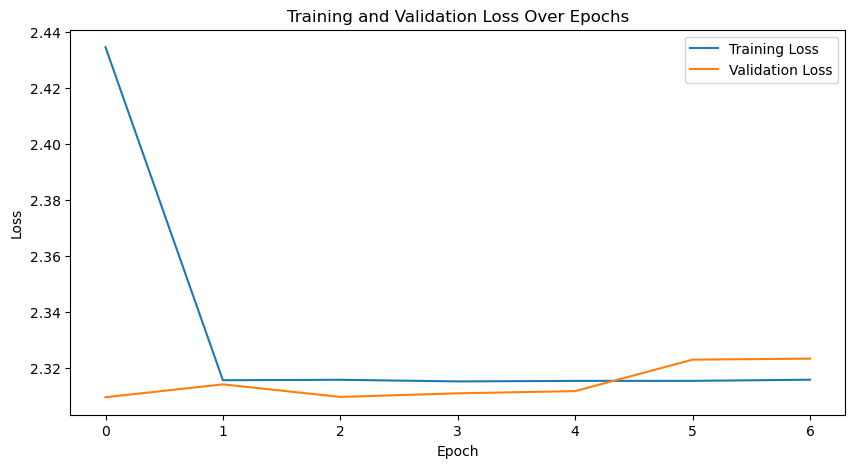

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list4, label='Training Loss')
plt.plot(v_losses_list4, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time4

datetime.timedelta(seconds=433, microseconds=768273)

In [ ]:
model_0001_learningrate = CNN4()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0001_learningrate.parameters(),lr=0.0001)
model_0001_learningrate , v_losses_list5 , t_losses_list5 , time5 = training(model_0001_learningrate,train_data , val_data , optimizer , loss_func,'model_1learningrate.pth')

train Accuracy of the model on the 8000 train images: 39.12%
in epoch 1 , i have train loss 1.6662984734535218
validation Accuracy of the model on the 2000 validation images: 51.44%
in epoch 1 , i have validation loss 1.34612333089018

train Accuracy of the model on the 8000 train images: 54.17%
in epoch 2 , i have train loss 1.2681933064460755
validation Accuracy of the model on the 2000 validation images: 58.23%
in epoch 2 , i have validation loss 1.169921634486689

train Accuracy of the model on the 8000 train images: 59.37%
in epoch 3 , i have train loss 1.1304672280311585
validation Accuracy of the model on the 2000 validation images: 61.19%
in epoch 3 , i have validation loss 1.080866458888252

train Accuracy of the model on the 8000 train images: 62.78%
in epoch 4 , i have train loss 1.042676210641861
validation Accuracy of the model on the 2000 validation images: 63.23%
in epoch 4 , i have validation loss 1.0325635635433867

train Accuracy of the model on the 8000 train images:

In [ ]:
model_0001_learningrate_res = testing(model_0001_learningrate , test_data)


test Accuracy of the model on the test images: 70.93%


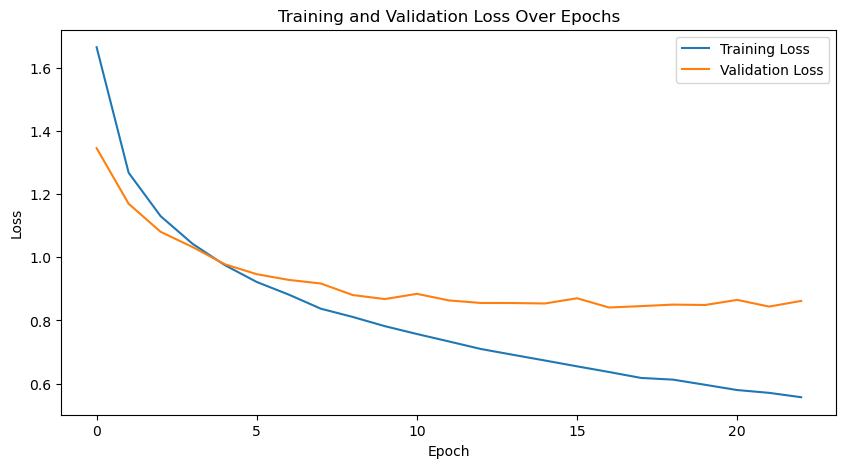

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list5, label='Training Loss')
plt.plot(v_losses_list5, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time5

datetime.timedelta(seconds=1508, microseconds=121837)

In [ ]:
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5 ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal4 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*2*2,256)
        self.dropout=nn.Dropout(p=0.3)
        self.output = nn.Linear(256,10)


    def forward(self,input_data):
        out = self.maxpool(F.leaky_relu(self.bNormal1(self.conv1(input_data))))
        out = self.maxpool(F.leaky_relu(self.bNormal2(self.conv2(out))))
        out = self.maxpool(F.leaky_relu(self.bNormal3(self.conv3(out))))
        out = self.maxpool(F.leaky_relu(self.bNormal4(self.conv4(out))))
        out = out.view(out.size(0) , -1)
        out = F.leaky_relu(self.hidden(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [ ]:
model_leaky_relu = CNN5()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_leaky_relu.parameters(),lr=0.001)
model_leaky_relu , v_losses_list6 , t_losses_list6 , time6 = training(model_leaky_relu,train_data , val_data , optimizer , loss_func,'model_1learningrate.pth')

train Accuracy of the model on the 8000 train images: 50.75%
in epoch 1 , i have train loss 1.3458060593605041
validation Accuracy of the model on the 2000 validation images: 62.67%
in epoch 1 , i have validation loss 1.0347179018270474

train Accuracy of the model on the 8000 train images: 64.34%
in epoch 2 , i have train loss 0.9994925856828689
validation Accuracy of the model on the 2000 validation images: 66.72%
in epoch 2 , i have validation loss 0.935503752182086

train Accuracy of the model on the 8000 train images: 68.76%
in epoch 3 , i have train loss 0.8840954076528549
validation Accuracy of the model on the 2000 validation images: 65.47%
in epoch 3 , i have validation loss 0.9921748601971343

train Accuracy of the model on the 8000 train images: 71.41%
in epoch 4 , i have train loss 0.8056704282283783
validation Accuracy of the model on the 2000 validation images: 69.30%
in epoch 4 , i have validation loss 0.8729797213222272

train Accuracy of the model on the 8000 train ima

In [ ]:
model_leaky_relu_res = testing(model_leaky_relu , test_data)


test Accuracy of the model on the test images: 74.41%


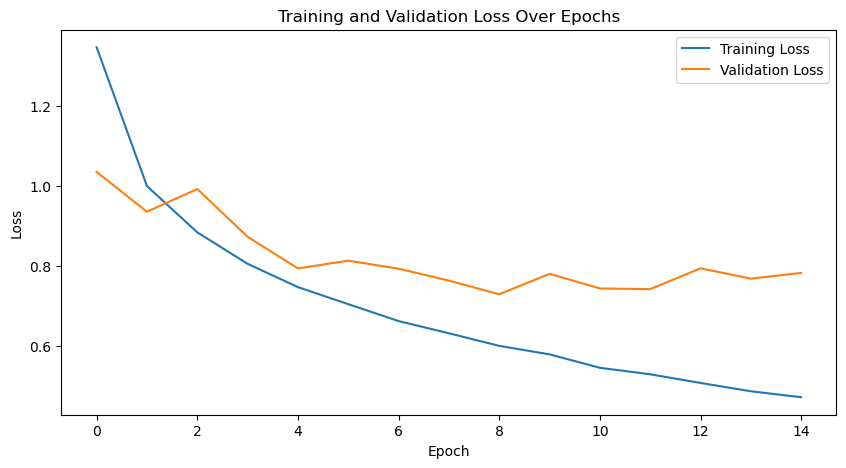

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list6, label='Training Loss')
plt.plot(v_losses_list6, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time6

datetime.timedelta(seconds=956, microseconds=571215)

In [ ]:
def swish(x):
    return x * torch.sigmoid(x)

In [ ]:
class CNN6(nn.Module):
    def __init__(self):
        super(CNN6 ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32 , out_channels=32 ,kernel_size=3 ,stride=1 , padding='same')
        self.bNormal4 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.hidden = nn.Linear(32*2*2,256)
        self.dropout=nn.Dropout(p=0.3)
        self.output = nn.Linear(256,10)


    def forward(self,input_data):
        out = self.maxpool(F.silu(self.bNormal1(self.conv1(input_data))))
        out = self.maxpool(F.silu(self.bNormal2(self.conv2(out))))
        out = self.maxpool(F.silu(self.bNormal3(self.conv3(out))))
        out = self.maxpool(F.silu(self.bNormal4(self.conv4(out))))
        out = out.view(out.size(0) , -1)
        out = F.silu(self.hidden(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [ ]:
model_swish = CNN6()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_swish.parameters(),lr=0.001)
model_swish , v_losses_list67, t_losses_list7 , time7 = training(model_swish,train_data , val_data , optimizer , loss_func,'model_1learningrate.pth')

train Accuracy of the model on the 8000 train images: 53.05%
in epoch 1 , i have train loss 1.2862126047611238
validation Accuracy of the model on the 2000 validation images: 63.86%
in epoch 1 , i have validation loss 1.005137485437119

train Accuracy of the model on the 8000 train images: 66.37%
in epoch 2 , i have train loss 0.952919441485405
validation Accuracy of the model on the 2000 validation images: 66.97%
in epoch 2 , i have validation loss 0.9301047930702234

train Accuracy of the model on the 8000 train images: 70.72%
in epoch 3 , i have train loss 0.8288220301389694
validation Accuracy of the model on the 2000 validation images: 70.30%
in epoch 3 , i have validation loss 0.8369166069327832

train Accuracy of the model on the 8000 train images: 73.59%
in epoch 4 , i have train loss 0.7519351306676865
validation Accuracy of the model on the 2000 validation images: 72.08%
in epoch 4 , i have validation loss 0.8043522997595631

train Accuracy of the model on the 8000 train imag

In [ ]:
model_swish_res = testing(model_swish , test_data)


test Accuracy of the model on the test images: 74.55%


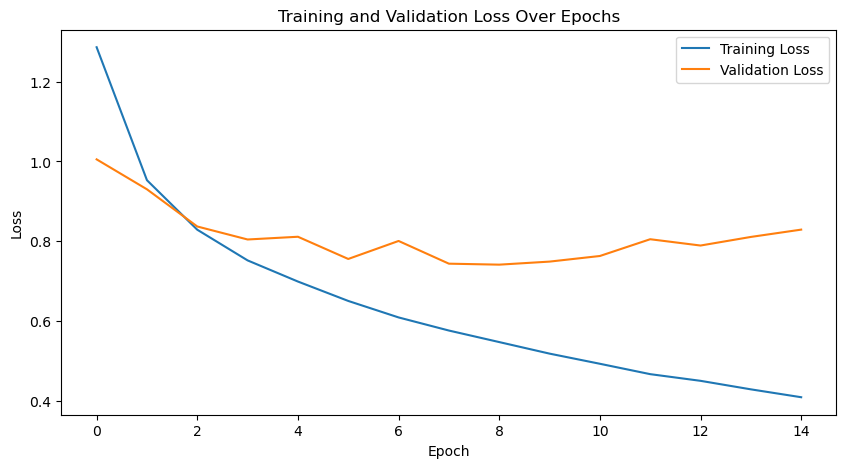

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list7, label='Training Loss')
plt.plot(v_losses_list67, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time7

datetime.timedelta(seconds=1025, microseconds=797532)

In [ ]:
model_adamw = CNN6()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_adamw.parameters(),lr=0.001,weight_decay=0.01)
model_adamw , v_losses_list8, t_losses_list8 , time8 = training(model_adamw,train_data , val_data , optimizer , loss_func,'adamw.pth')

train Accuracy of the model on the 8000 train images: 53.28%
in epoch 1 , i have train loss 1.294038236618042
validation Accuracy of the model on the 2000 validation images: 64.28%
in epoch 1 , i have validation loss 1.0021073684905664

train Accuracy of the model on the 8000 train images: 66.59%
in epoch 2 , i have train loss 0.94530288875103
validation Accuracy of the model on the 2000 validation images: 67.48%
in epoch 2 , i have validation loss 0.9277430091993496

train Accuracy of the model on the 8000 train images: 70.93%
in epoch 3 , i have train loss 0.8211573706388473
validation Accuracy of the model on the 2000 validation images: 70.12%
in epoch 3 , i have validation loss 0.8429525880196604

train Accuracy of the model on the 8000 train images: 73.99%
in epoch 4 , i have train loss 0.7432979861855507
validation Accuracy of the model on the 2000 validation images: 72.32%
in epoch 4 , i have validation loss 0.7828893062596123

train Accuracy of the model on the 8000 train image

In [ ]:
model_adamw_res = testing(model_adamw , test_data)


test Accuracy of the model on the test images: 74.84%


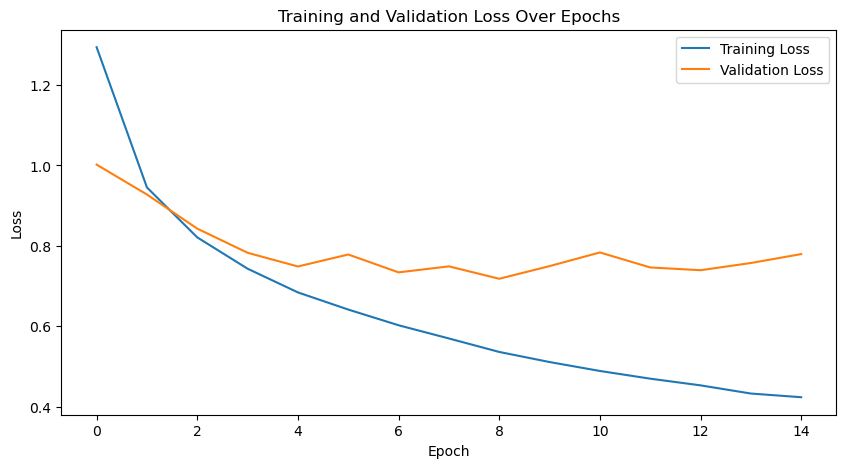

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list8, label='Training Loss')
plt.plot(v_losses_list8, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time8

datetime.timedelta(seconds=1021, microseconds=611044)

In [ ]:
torch.save(model_adamw.state_dict(), 'best.pth')

In [ ]:
model_SGD = CNN6()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_SGD.parameters(),lr=0.001)
model_SGD , v_losses_list9, t_losses_list9 , time9 = training(model_SGD,train_data , val_data , optimizer , loss_func,'sgd.pth')

train Accuracy of the model on the 8000 train images: 21.84%
in epoch 1 , i have train loss 2.1659827273368837
validation Accuracy of the model on the 2000 validation images: 30.82%
in epoch 1 , i have validation loss 2.004469130366755

train Accuracy of the model on the 8000 train images: 31.75%
in epoch 2 , i have train loss 1.9132476077079772
validation Accuracy of the model on the 2000 validation images: 36.68%
in epoch 2 , i have validation loss 1.777269346645465

train Accuracy of the model on the 8000 train images: 37.34%
in epoch 3 , i have train loss 1.72323451461792
validation Accuracy of the model on the 2000 validation images: 42.59%
in epoch 3 , i have validation loss 1.607079077071656

train Accuracy of the model on the 8000 train images: 42.42%
in epoch 4 , i have train loss 1.5870135370254517
validation Accuracy of the model on the 2000 validation images: 46.40%
in epoch 4 , i have validation loss 1.4915807228118847

train Accuracy of the model on the 8000 train images:

train Accuracy of the model on the 8000 train images: 75.46%
in epoch 36 , i have train loss 0.6941576295375824
validation Accuracy of the model on the 2000 validation images: 71.52%
in epoch 36 , i have validation loss 0.8334221753259056

train Accuracy of the model on the 8000 train images: 75.68%
in epoch 37 , i have train loss 0.6881749809980392
validation Accuracy of the model on the 2000 validation images: 71.45%
in epoch 37 , i have validation loss 0.832476859942031

Early stopping triggered


In [ ]:
model_sgd_res = testing(model_SGD , test_data)


test Accuracy of the model on the test images: 70.49%


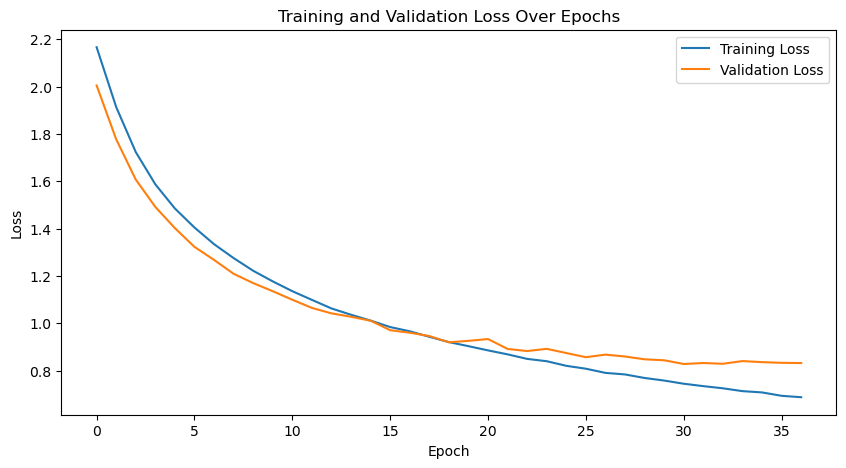

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list9, label='Training Loss')
plt.plot(v_losses_list9, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time9

datetime.timedelta(seconds=2214, microseconds=16368)

In [ ]:
train_data1 = DataLoader(train , batch_size = 4 , shuffle = True)
val_data1 = DataLoader(val , batch_size = 4 , shuffle = False)
test_data1 = DataLoader(test , batch_size = 4 , shuffle = False)

In [ ]:
model_4batch = CNN6()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_4batch.parameters(),lr=0.001,weight_decay=0.01)
model_4batch , v_losses_list10, t_losses_list10 , time10 = training(model_4batch,train_data1 , val_data1 , optimizer , loss_func,'adamw4.pth')

train Accuracy of the model on the 8000 train images: 49.99%
in epoch 1 , i have train loss 1.3891516101829708
validation Accuracy of the model on the 2000 validation images: 62.22%
in epoch 1 , i have validation loss 1.050677353709936

train Accuracy of the model on the 8000 train images: 62.79%
in epoch 2 , i have train loss 1.0534063543390482
validation Accuracy of the model on the 2000 validation images: 66.53%
in epoch 2 , i have validation loss 0.9505492557443679

train Accuracy of the model on the 8000 train images: 67.47%
in epoch 3 , i have train loss 0.9261912939768284
validation Accuracy of the model on the 2000 validation images: 67.40%
in epoch 3 , i have validation loss 0.9185718237180263

train Accuracy of the model on the 8000 train images: 69.69%
in epoch 4 , i have train loss 0.8612557128150947
validation Accuracy of the model on the 2000 validation images: 71.07%
in epoch 4 , i have validation loss 0.8201472488751635

train Accuracy of the model on the 8000 train ima

In [ ]:
model_4batch_res = testing(model_4batch , test_data1)


test Accuracy of the model on the test images: 72.67%


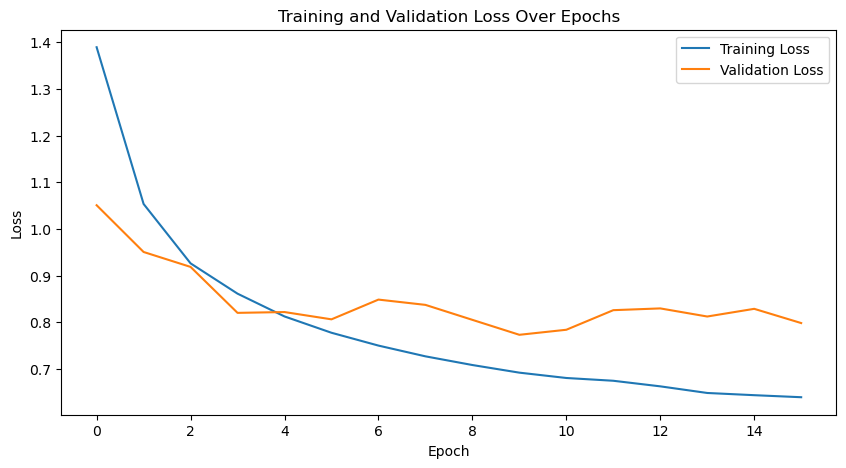

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list10, label='Training Loss')
plt.plot(v_losses_list10, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time10

datetime.timedelta(seconds=2108, microseconds=602990)

In [ ]:
train_data2 = DataLoader(train , batch_size = 128 , shuffle = True)
val_data2 = DataLoader(val , batch_size = 128 , shuffle = False)
test_data2 = DataLoader(test , batch_size = 128 , shuffle = False)

In [ ]:
model_128batch = CNN6()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_128batch.parameters(),lr=0.001,weight_decay=0.01)
model_128batch , v_losses_list11, t_losses_list11 , time11 = training(model_128batch,train_data2 , val_data2 , optimizer , loss_func,'adamw128.pth')

train Accuracy of the model on the 8000 train images: 49.28%
in epoch 1 , i have train loss 1.3876734345484847
validation Accuracy of the model on the 2000 validation images: 58.65%
in epoch 1 , i have validation loss 1.1672722621809077

train Accuracy of the model on the 8000 train images: 63.56%
in epoch 2 , i have train loss 1.0186036295784167
validation Accuracy of the model on the 2000 validation images: 65.95%
in epoch 2 , i have validation loss 0.9644061010095137

train Accuracy of the model on the 8000 train images: 68.94%
in epoch 3 , i have train loss 0.8730163408544498
validation Accuracy of the model on the 2000 validation images: 69.59%
in epoch 3 , i have validation loss 0.8591084691542613

train Accuracy of the model on the 8000 train images: 72.27%
in epoch 4 , i have train loss 0.783788301883795
validation Accuracy of the model on the 2000 validation images: 70.05%
in epoch 4 , i have validation loss 0.8608728541603571

train Accuracy of the model on the 8000 train ima

In [ ]:
model_128batch_res = testing(model_128batch , test_data2)


test Accuracy of the model on the test images: 73.32%


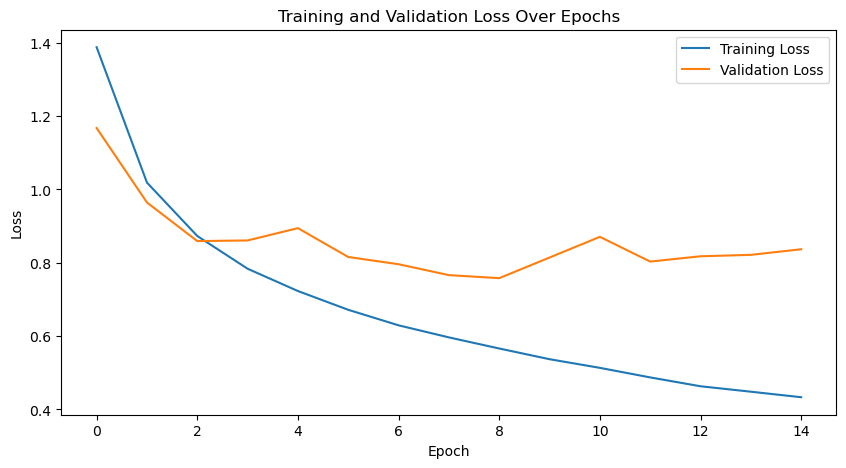

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list11, label='Training Loss')
plt.plot(v_losses_list11, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time11

datetime.timedelta(seconds=868, microseconds=795183)

In [ ]:
model_for_kernel_vis = CNN6()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_for_kernel_vis.parameters(),lr=0.001,weight_decay=0.01)
model_for_kernel_vis , v_losses_list12, t_losses_list12 , time12 = training(model_for_kernel_vis,train_data , val_data , optimizer , loss_func,'adamw_vis.pth')

train Accuracy of the model on the 8000 train images: 52.48%
in epoch 1 , i have train loss 1.3097499412536622
validation Accuracy of the model on the 2000 validation images: 61.53%
in epoch 1 , i have validation loss 1.0924453851513969

train Accuracy of the model on the 8000 train images: 66.04%
in epoch 2 , i have train loss 0.9565945045232773
validation Accuracy of the model on the 2000 validation images: 69.83%
in epoch 2 , i have validation loss 0.8572521062133411

train Accuracy of the model on the 8000 train images: 71.08%
in epoch 3 , i have train loss 0.8250604840517044
validation Accuracy of the model on the 2000 validation images: 70.60%
in epoch 3 , i have validation loss 0.8377479656626241

train Accuracy of the model on the 8000 train images: 73.79%
in epoch 4 , i have train loss 0.7486171959400177
validation Accuracy of the model on the 2000 validation images: 70.81%
in epoch 4 , i have validation loss 0.8402152215710844

train Accuracy of the model on the 8000 train im

In [ ]:
model_for_kernel_vis_res = testing(model_for_kernel_vis , test_data)


test Accuracy of the model on the test images: 75.36%


In [ ]:
torch.save(model_for_kernel_vis.state_dict(), 'best.pth')

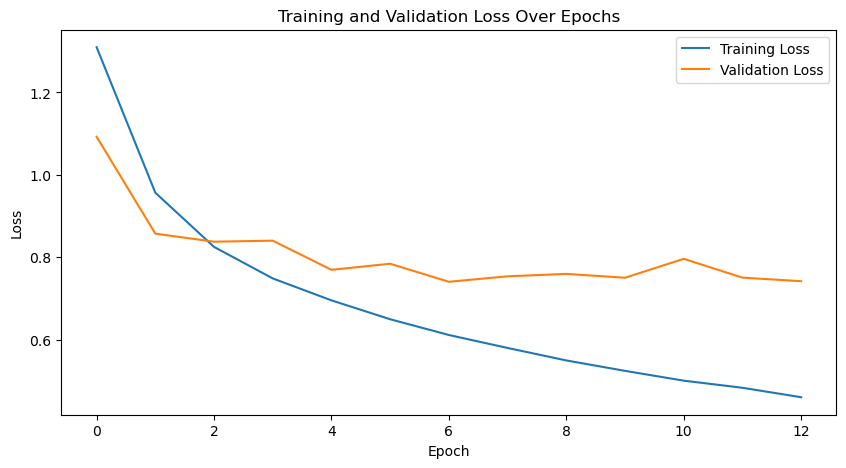

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list12, label='Training Loss')
plt.plot(v_losses_list12, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
time12

datetime.timedelta(seconds=854, microseconds=693040)

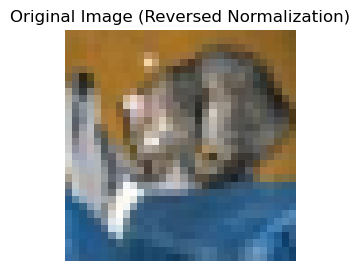

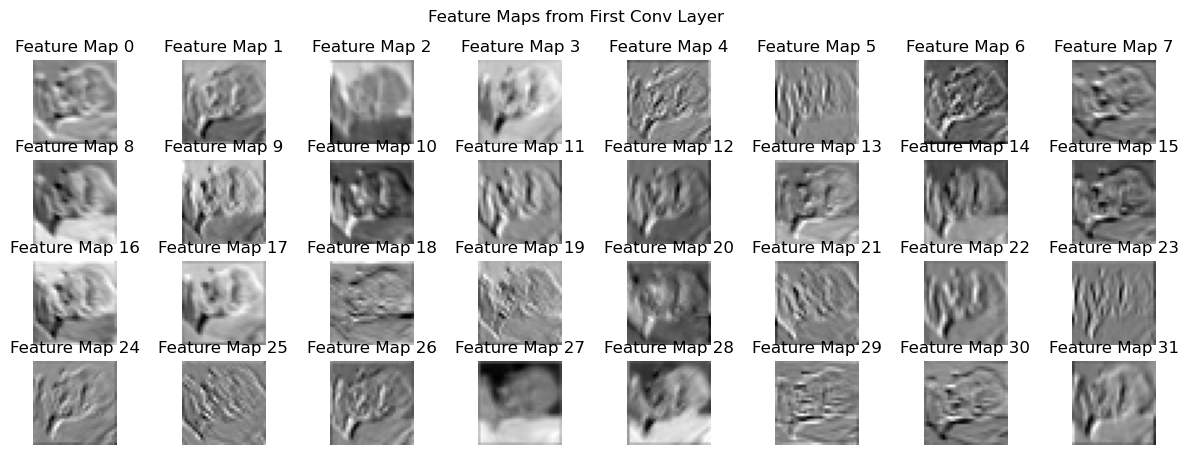

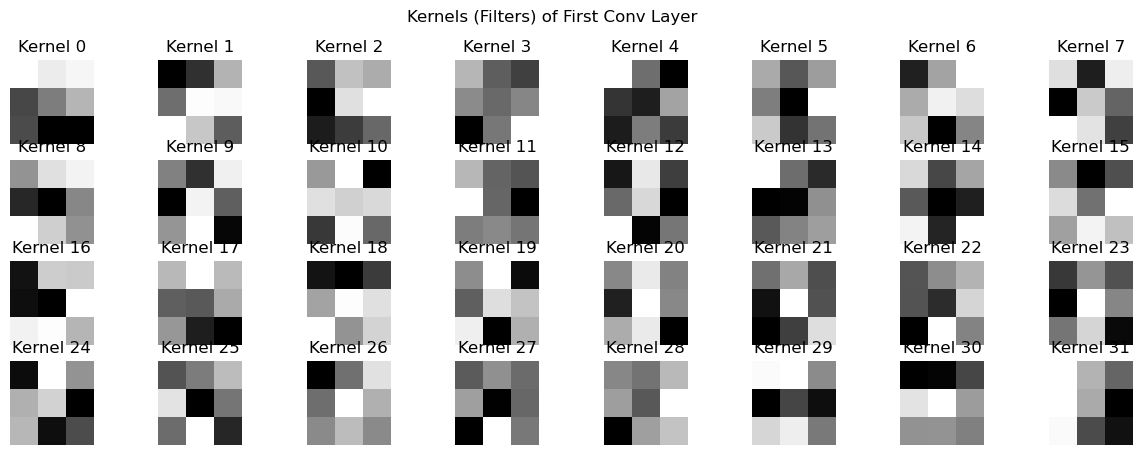

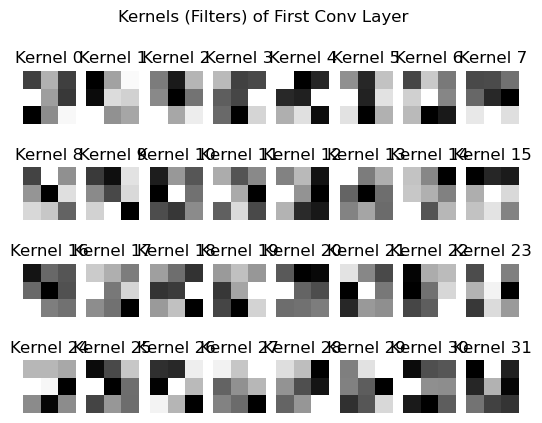

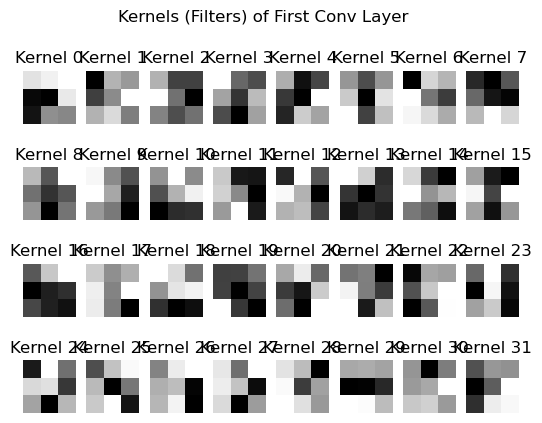

In [ ]:


# Move the model and data to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_for_kernel_vis = model_for_kernel_vis.to(device)
images = images.to(device)

# Take the first image in the batch for visualization
image = images[0].unsqueeze(0)  # Add batch dimension for a single image [1, 3, 32, 32]

original_image = images[0].cpu()  # Shape: [3, 32, 32]

# Reverse normalization: multiply by std and add mean for each channel
original_image = original_image / 2 + 0.5  # This reverses the (0.5, 0.5, 0.5) normalization

# Permute dimensions to [H, W, C] for matplotlib
original_image = original_image.permute(1, 2, 0)

# Clip the values to be in the range [0, 1] for proper display
original_image = torch.clamp(original_image, 0, 1)

# Display the original image
plt.figure(figsize=(3, 3))
plt.imshow(original_image)
plt.title("Original Image (Reversed Normalization)")
plt.axis('off')
plt.show()


# Step 1: Pass the image through the first convolutional layer
first_conv_layer = model_for_kernel_vis.conv1  # Access the first conv layer
feature_maps = first_conv_layer(image)  # Get feature maps from first layer

# Move feature maps to CPU for visualization and remove batch dimension
feature_maps = feature_maps.detach().cpu().squeeze(0)

# Step 2: Visualize the Feature Maps
plt.figure(figsize=(15, 5))
num_filters = feature_maps.shape[0]  # Number of feature maps (out_channels in the first conv layer)
for i in range(num_filters):
    plt.subplot(4, num_filters // 4, i + 1)
    plt.imshow(feature_maps[i].numpy(), cmap='gray')
    plt.title(f"Feature Map {i}")
    plt.axis('off')
plt.suptitle("Feature Maps from First Conv Layer")
plt.show()

# Step 3: Visualize the Kernels (Filters) of the First Convolutional Layer
kernels = model_for_kernel_vis.conv1.weight.detach().cpu()  # Shape: [out_channels, in_channels, kernel_height, kernel_width]

plt.figure(figsize=(15, 5))
num_kernels = kernels.shape[0]  # Number of kernels (filters)
for j in range(3):
    for i in range(num_kernels):
        # For simplicity, visualize only the first channel of each filter
        kernel = kernels[i, j, :, :]  # Take the first channel of each kernel
        plt.subplot(4, num_kernels // 4, i + 1)
        plt.imshow(kernel, cmap='gray')
        plt.title(f"Kernel {i}")
        plt.axis('off')
    plt.suptitle("Kernels (Filters) of First Conv Layer")
    plt.show()

In [ ]:
def imageshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

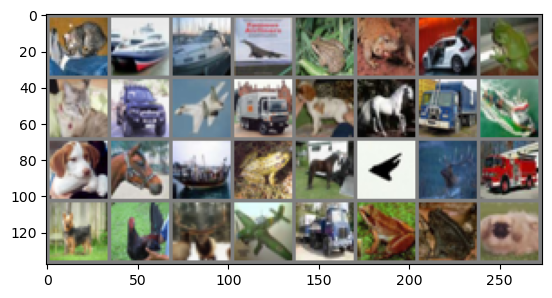

True labels:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 
Predicted:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck cat   horse truck ship 


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(test_data)
images, labels = next(dataiter)

imageshow(torchvision.utils.make_grid(images))
print('True labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

outputs = model_for_kernel_vis(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(16)))

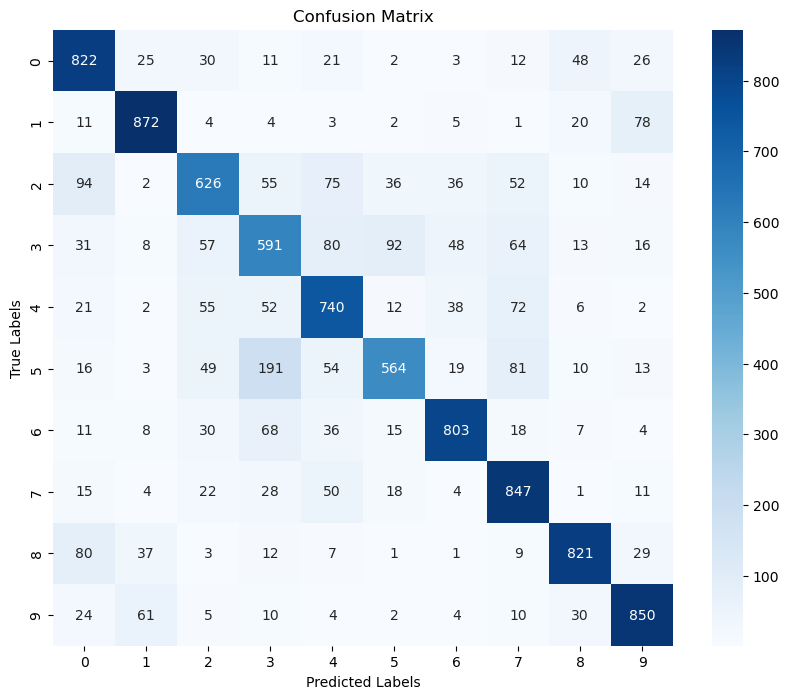

In [ ]:
model_for_kernel_vis.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)

        outputs = model_for_kernel_vis(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)


# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [4]:
model_resnet = torchvision.models.resnet50(pretrained=True)

model_resnet.fc = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.2MB/s]


In [4]:
transform1 = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to fit ResNet50 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform1)

validation_ratio = 0.2
train_size = int((1-validation_ratio) * len(full_train_dataset))
validation_size = len(full_train_dataset) - train_size
trainset, validationset = random_split(full_train_dataset, [train_size, validation_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=32, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
for param in model_resnet.parameters():
    param.requires_grad = False

# عnfreeze the final fully connected layer
for param in model_resnet.fc.parameters():
    param.requires_grad = True

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_resnet.fc.parameters(), lr=0.001)  # Only updating the FC layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

In [16]:
model_resnet , v_losses_list13, t_losses_list13 , time13 = training(model_resnet,trainloader , validationloader , optimizer , criterion,'mode_resnet.pth',patience=3)

train Accuracy of the model on the 8000 train images: 84.88%
in epoch 1 , i have train loss 0.426697068887949
validation Accuracy of the model on the 2000 validation images: 83.45%
in epoch 1 , i have validation loss 0.5158438303362066

train Accuracy of the model on the 8000 train images: 85.43%
in epoch 2 , i have train loss 0.41857805951535704
validation Accuracy of the model on the 2000 validation images: 83.49%
in epoch 2 , i have validation loss 0.5006605010158338

train Accuracy of the model on the 8000 train images: 85.30%
in epoch 3 , i have train loss 0.41182778776884077
validation Accuracy of the model on the 2000 validation images: 82.77%
in epoch 3 , i have validation loss 0.5318034734731665

train Accuracy of the model on the 8000 train images: 85.89%
in epoch 4 , i have train loss 0.3992343337059021
validation Accuracy of the model on the 2000 validation images: 83.29%
in epoch 4 , i have validation loss 0.5170637692649144

train Accuracy of the model on the 8000 train i

In [23]:
model_resnet_res = testing(model_resnet , testloader)

test Accuracy of the model on the test images: 82.37%


In [17]:
torch.save(model_resnet.state_dict(), 'resnet.pth')

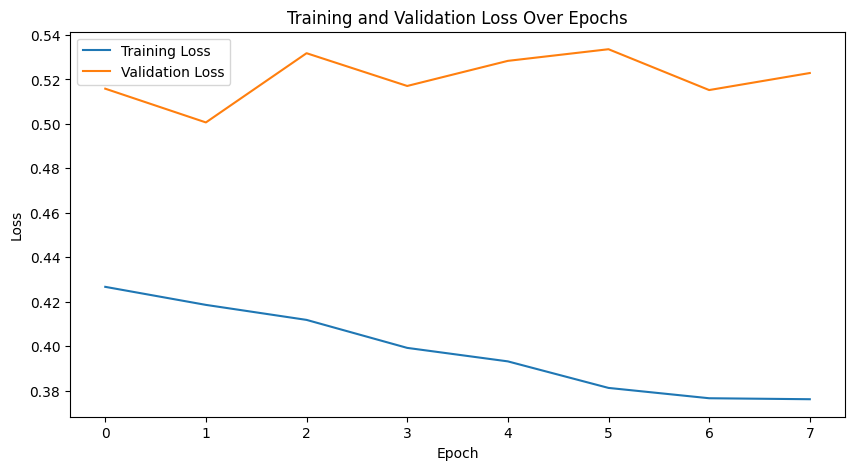

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list13, label='Training Loss')
plt.plot(v_losses_list13, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [19]:
time13

datetime.timedelta(seconds=1709, microseconds=309039)

In [6]:
model_EfficientNet = torchvision.models.efficientnet_b0(pretrained=True)

model_EfficientNet.fc = nn.Sequential(
    nn.Linear(model_EfficientNet.classifier[1].in_features , 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [7]:
for param in model_EfficientNet.parameters():
    param.requires_grad = False

# unfreeze the final fully connected layer
for param in model_EfficientNet.classifier.parameters():
    param.requires_grad = True

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model_EfficientNet.classifier.parameters(), lr=0.001)  # Only updating the FC layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_EfficientNet = model_EfficientNet.to(device)

In [11]:
model_EfficientNet , v_losses_list14, t_losses_list14 , time14 = training(model_EfficientNet,trainloader , validationloader , optimizer , criterion,'model_effi.pth',patience=5)

train Accuracy of the model on the 8000 train images: 64.88%
in epoch 1 , i have train loss 1.1273823511838914
validation Accuracy of the model on the 2000 validation images: 78.35%
in epoch 1 , i have validation loss 0.682350114368783

train Accuracy of the model on the 8000 train images: 74.10%
in epoch 2 , i have train loss 0.7679727908372879
validation Accuracy of the model on the 2000 validation images: 79.54%
in epoch 2 , i have validation loss 0.6251982966074928

train Accuracy of the model on the 8000 train images: 75.40%
in epoch 3 , i have train loss 0.727930471587181
validation Accuracy of the model on the 2000 validation images: 80.08%
in epoch 3 , i have validation loss 0.6062109570343274

train Accuracy of the model on the 8000 train images: 76.06%
in epoch 4 , i have train loss 0.7118320826172828
validation Accuracy of the model on the 2000 validation images: 81.03%
in epoch 4 , i have validation loss 0.5831976889516599

train Accuracy of the model on the 8000 train imag

In [12]:
model_EfficientNet_res = testing(model_EfficientNet , testloader)

test Accuracy of the model on the test images: 80.52%


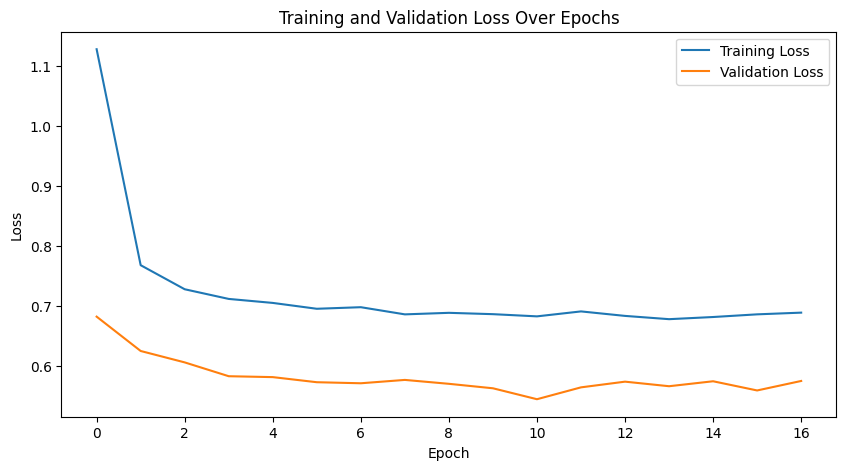

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(t_losses_list14, label='Training Loss')
plt.plot(v_losses_list14, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [14]:
time14

datetime.timedelta(seconds=2305, microseconds=447924)